In [3]:
import importlib
import os
import sys
sys.path.append("../src/utils")
import evaluation_utils
importlib.reload(evaluation_utils)
from evaluation_utils import *

from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
import numpy as np
import lightgbm as lgb

In [4]:
XCAP_MODEL_PATH = "/cluster/u/rrastogi/ECNN/results/d_original/xcap/featurize_0520/clf.mdl"
xcap_clf = lgb.Booster(model_file=XCAP_MODEL_PATH)

In [47]:
def plotRocHelper(labels, predictions, clf_name, legend, hsr, abl_line=False):
    fpr, tpr, _ = roc_curve(labels, predictions)
    auroc = auc(fpr, tpr) if not hsr else getHsrAuc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='-' if not abl_line else 'dotted')
    legend.append("{}: {:0.3f}".format(clf_name, round(auroc, 3)))
    print("{}: threshold={}, TNR @ 95% sensitivity: {}".format(
        clf_name,
        getHsThreshold(labels, predictions),
        getHsTnr(labels, predictions)
    ))
    
def create_title(metric, d_original=True):
    dataset = "$D_{original}$" if d_original else "$D_{validation}$"
    return "{} ({})".format(metric, dataset)

def plotRoc(d_original=True, hsr=False):
    figsize=(9, 6) if d_original else (5, 4)
    
    plt.figure(figsize=figsize, dpi=300)
    
    results_dir = "/cluster/u/rrastogi/ECNN/results"
    dataset_dir = "d_original" if d_original else "d_validation"
    xcap_features_path = os.path.join(results_dir, dataset_dir, "xcap", "featurize_0520", "total_test.features")
    aloft_results_path = os.path.join(results_dir, dataset_dir, "aloft", "total", "aloft_output", "hg19.aloft.lof.results")
    aloft_hg38_vcf_path = os.path.join(results_dir, dataset_dir, "aloft", "total", "hg38.vcf")
    mutpred_input_path = os.path.join(results_dir, dataset_dir, "mutpred", "total", "subset.tsv")
    mutpred_results_path = os.path.join(results_dir, dataset_dir, "mutpred", "total", "results_output.txt")
    if d_original:
        wgp_input_path = os.path.join(results_dir, dataset_dir, "preprocess", "collate", "total_test.tsv")
    else:
        wgp_input_path = os.path.join(results_dir, dataset_dir, "preprocess", "remove_train", "test.tsv")
    wgp_results_path = os.path.join(results_dir, dataset_dir, "wgp", "total", "avinput.hg38_multianno.txt")
    
    legend = []
    
    # XCAP
    if d_original:
        xcap_labels, xcap_predictions = get_xcap_predictions(xcap_clf, xcap_features_path)
        plotRocHelper(xcap_labels, xcap_predictions, "X-CAP (trained on $D_{original}$, n=166,804)", legend, hsr)
        
        datasets_ablation_dir = "/cluster/u/rrastogi/ECNN/ablation/dataset"
        xcap_trained_on_mutpred_data_clf = lgb.Booster(
            model_file=os.path.join(datasets_ablation_dir, "mutpred/clf_subsample_augment.mdl"))
        xcap_labels, xcap_predictions = get_xcap_predictions(xcap_trained_on_mutpred_data_clf,
            xcap_features_path)
        plotRocHelper(xcap_labels, xcap_predictions, "X-CAP (trained on MutPred-LoF data, n=22,278)", 
            legend, hsr, abl_line=True)

        xcap_trained_on_aloft_data_clf = lgb.Booster(
            model_file=os.path.join(datasets_ablation_dir, "aloft/clf_subsample_augment.mdl"))
        xcap_labels, xcap_predictions = get_xcap_predictions(xcap_trained_on_aloft_data_clf,
            xcap_features_path)
        plotRocHelper(xcap_labels, xcap_predictions, "X-CAP (trained on ALoFT data, n=1,517)", 
            legend, hsr, abl_line=True)
        
    # ALoFT
    aloft_labels, aloft_predictions, _ = get_aloft_predictions(aloft_results_path, aloft_hg38_vcf_path)
    plotRocHelper(aloft_labels, aloft_predictions, "ALoFT", legend, hsr)
    
    # MutPred-LoF
    mutpred_labels, mutpred_predictions = get_mutpred_predictions(mutpred_input_path, mutpred_results_path)
    plotRocHelper(mutpred_labels, mutpred_predictions, "MutPred-LoF", legend, hsr)
    
    # CADD
    cadd_labels, cadd_predictions = get_cadd_predictions(wgp_input_path, wgp_results_path)
    plotRocHelper(cadd_labels, cadd_predictions, "CADD", legend, hsr)
    
    # DANN
    dann_labels, dann_predictions = get_dann_predictions(wgp_input_path, wgp_results_path)
    plotRocHelper(dann_labels, dann_predictions, "DANN", legend, hsr)
    
    # Eigen
    eigen_labels, eigen_predictions = get_eigen_predictions(wgp_input_path, wgp_results_path)
    plotRocHelper(eigen_labels, eigen_predictions, "Eigen", legend, hsr)
    
    if d_original and not hsr:
        plt.axhline(y=0.95, color="k", linestyle='dashed')
        legend.append("95% sensitivity threshold")
    
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0] if not hsr else [0.95, 1.0])
    metric = "hsr-ROC" if hsr else "ROC"
    plt.title(create_title(metric, d_original=d_original))
    
    plt.legend(legend, loc="lower right" if not hsr else "upper left")
    plt.show()

In [52]:
def plotPrcHelper(labels, predictions, clf_name, legend):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    ap = average_precision_score(labels, predictions)
    plt.plot(recall, precision)
    legend.append("{}: {:0.3f}".format(clf_name, round(ap, 3)))

def plotPrc(d_original=True):
    plt.figure(figsize=(5, 5), dpi=300)
        
    results_dir = "/cluster/u/rrastogi/ECNN/results"
    dataset_dir = "d_original" if d_original else "d_validation"
    xcap_features_path = os.path.join(results_dir, dataset_dir, "xcap", "featurize_0520", "total_test.features")
    aloft_results_path = os.path.join(results_dir, dataset_dir, "aloft", "total", "aloft_output", "hg19.aloft.lof.results")
    aloft_hg38_vcf_path = os.path.join(results_dir, dataset_dir, "aloft", "total", "hg38.vcf")
    mutpred_input_path = os.path.join(results_dir, dataset_dir, "mutpred", "total", "subset.tsv")
    mutpred_results_path = os.path.join(results_dir, dataset_dir, "mutpred", "total", "results_output.txt")
    if d_original:
        wgp_input_path = os.path.join(results_dir, dataset_dir, "preprocess", "collate", "total_test.tsv")
    else:
        wgp_input_path = os.path.join(results_dir, dataset_dir, "preprocess", "remove_train", "test.tsv")
    wgp_results_path = os.path.join(results_dir, dataset_dir, "wgp", "total", "avinput.hg38_multianno.txt")
    
    legend = []
    
    # XCAP
    xcap_labels, xcap_predictions = get_xcap_predictions(xcap_clf, xcap_features_path)
    plotPrcHelper(xcap_labels, xcap_predictions, "X-CAP", legend)
    
    # ALoFT
    aloft_labels, aloft_predictions, _ = get_aloft_predictions(aloft_results_path, aloft_hg38_vcf_path)
    plotPrcHelper(aloft_labels, aloft_predictions, "ALoFT", legend)
    
    # MutPred-LoF
    mutpred_labels, mutpred_predictions = get_mutpred_predictions(mutpred_input_path, mutpred_results_path)
    plotPrcHelper(mutpred_labels, mutpred_predictions, "MutPred-LoF", legend)
    
    # CADD
    cadd_labels, cadd_predictions = get_cadd_predictions(wgp_input_path, wgp_results_path)
    plotPrcHelper(cadd_labels, cadd_predictions, "CADD", legend)
    
    # DANN
    dann_labels, dann_predictions = get_dann_predictions(wgp_input_path, wgp_results_path)
    plotPrcHelper(dann_labels, dann_predictions, "DANN", legend)
    
    # Eigen
    eigen_labels, eigen_predictions = get_eigen_predictions(wgp_input_path, wgp_results_path)
    plotPrcHelper(eigen_labels, eigen_predictions, "Eigen", legend)
    
    # High-sensitivity region cutoff
    plt.axvline(x=0.95, color="k", linestyle="dashed")
    legend.append("95% sensitivity threshold")
    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(create_title("PRC", d_original=d_original))
    plt.legend(legend, loc="upper right")
    plt.show()

# D_original

X-CAP (trained on $D_{original}$, n=166,804): threshold=0.06011546409371992, TNR @ 95% sensitivity: 0.7992762213764273
X-CAP (trained on MutPred-LoF data, n=22,278): threshold=0.001510988808785341, TNR @ 95% sensitivity: 0.7366943283209584
X-CAP (trained on ALoFT data, n=1,517): threshold=0.3205990202127476, TNR @ 95% sensitivity: 0.6663130966494042
ALoFT: threshold=0.062275, TNR @ 95% sensitivity: 0.17551631621638486
MutPred-LoF: threshold=0.29098, TNR @ 95% sensitivity: 0.07683615819209044
CADD: threshold=33.0, TNR @ 95% sensitivity: 0.13483496599488365
DANN: threshold=0.97, TNR @ 95% sensitivity: 0.13545891308417046
Eigen: threshold=-2.007, TNR @ 95% sensitivity: 0.0


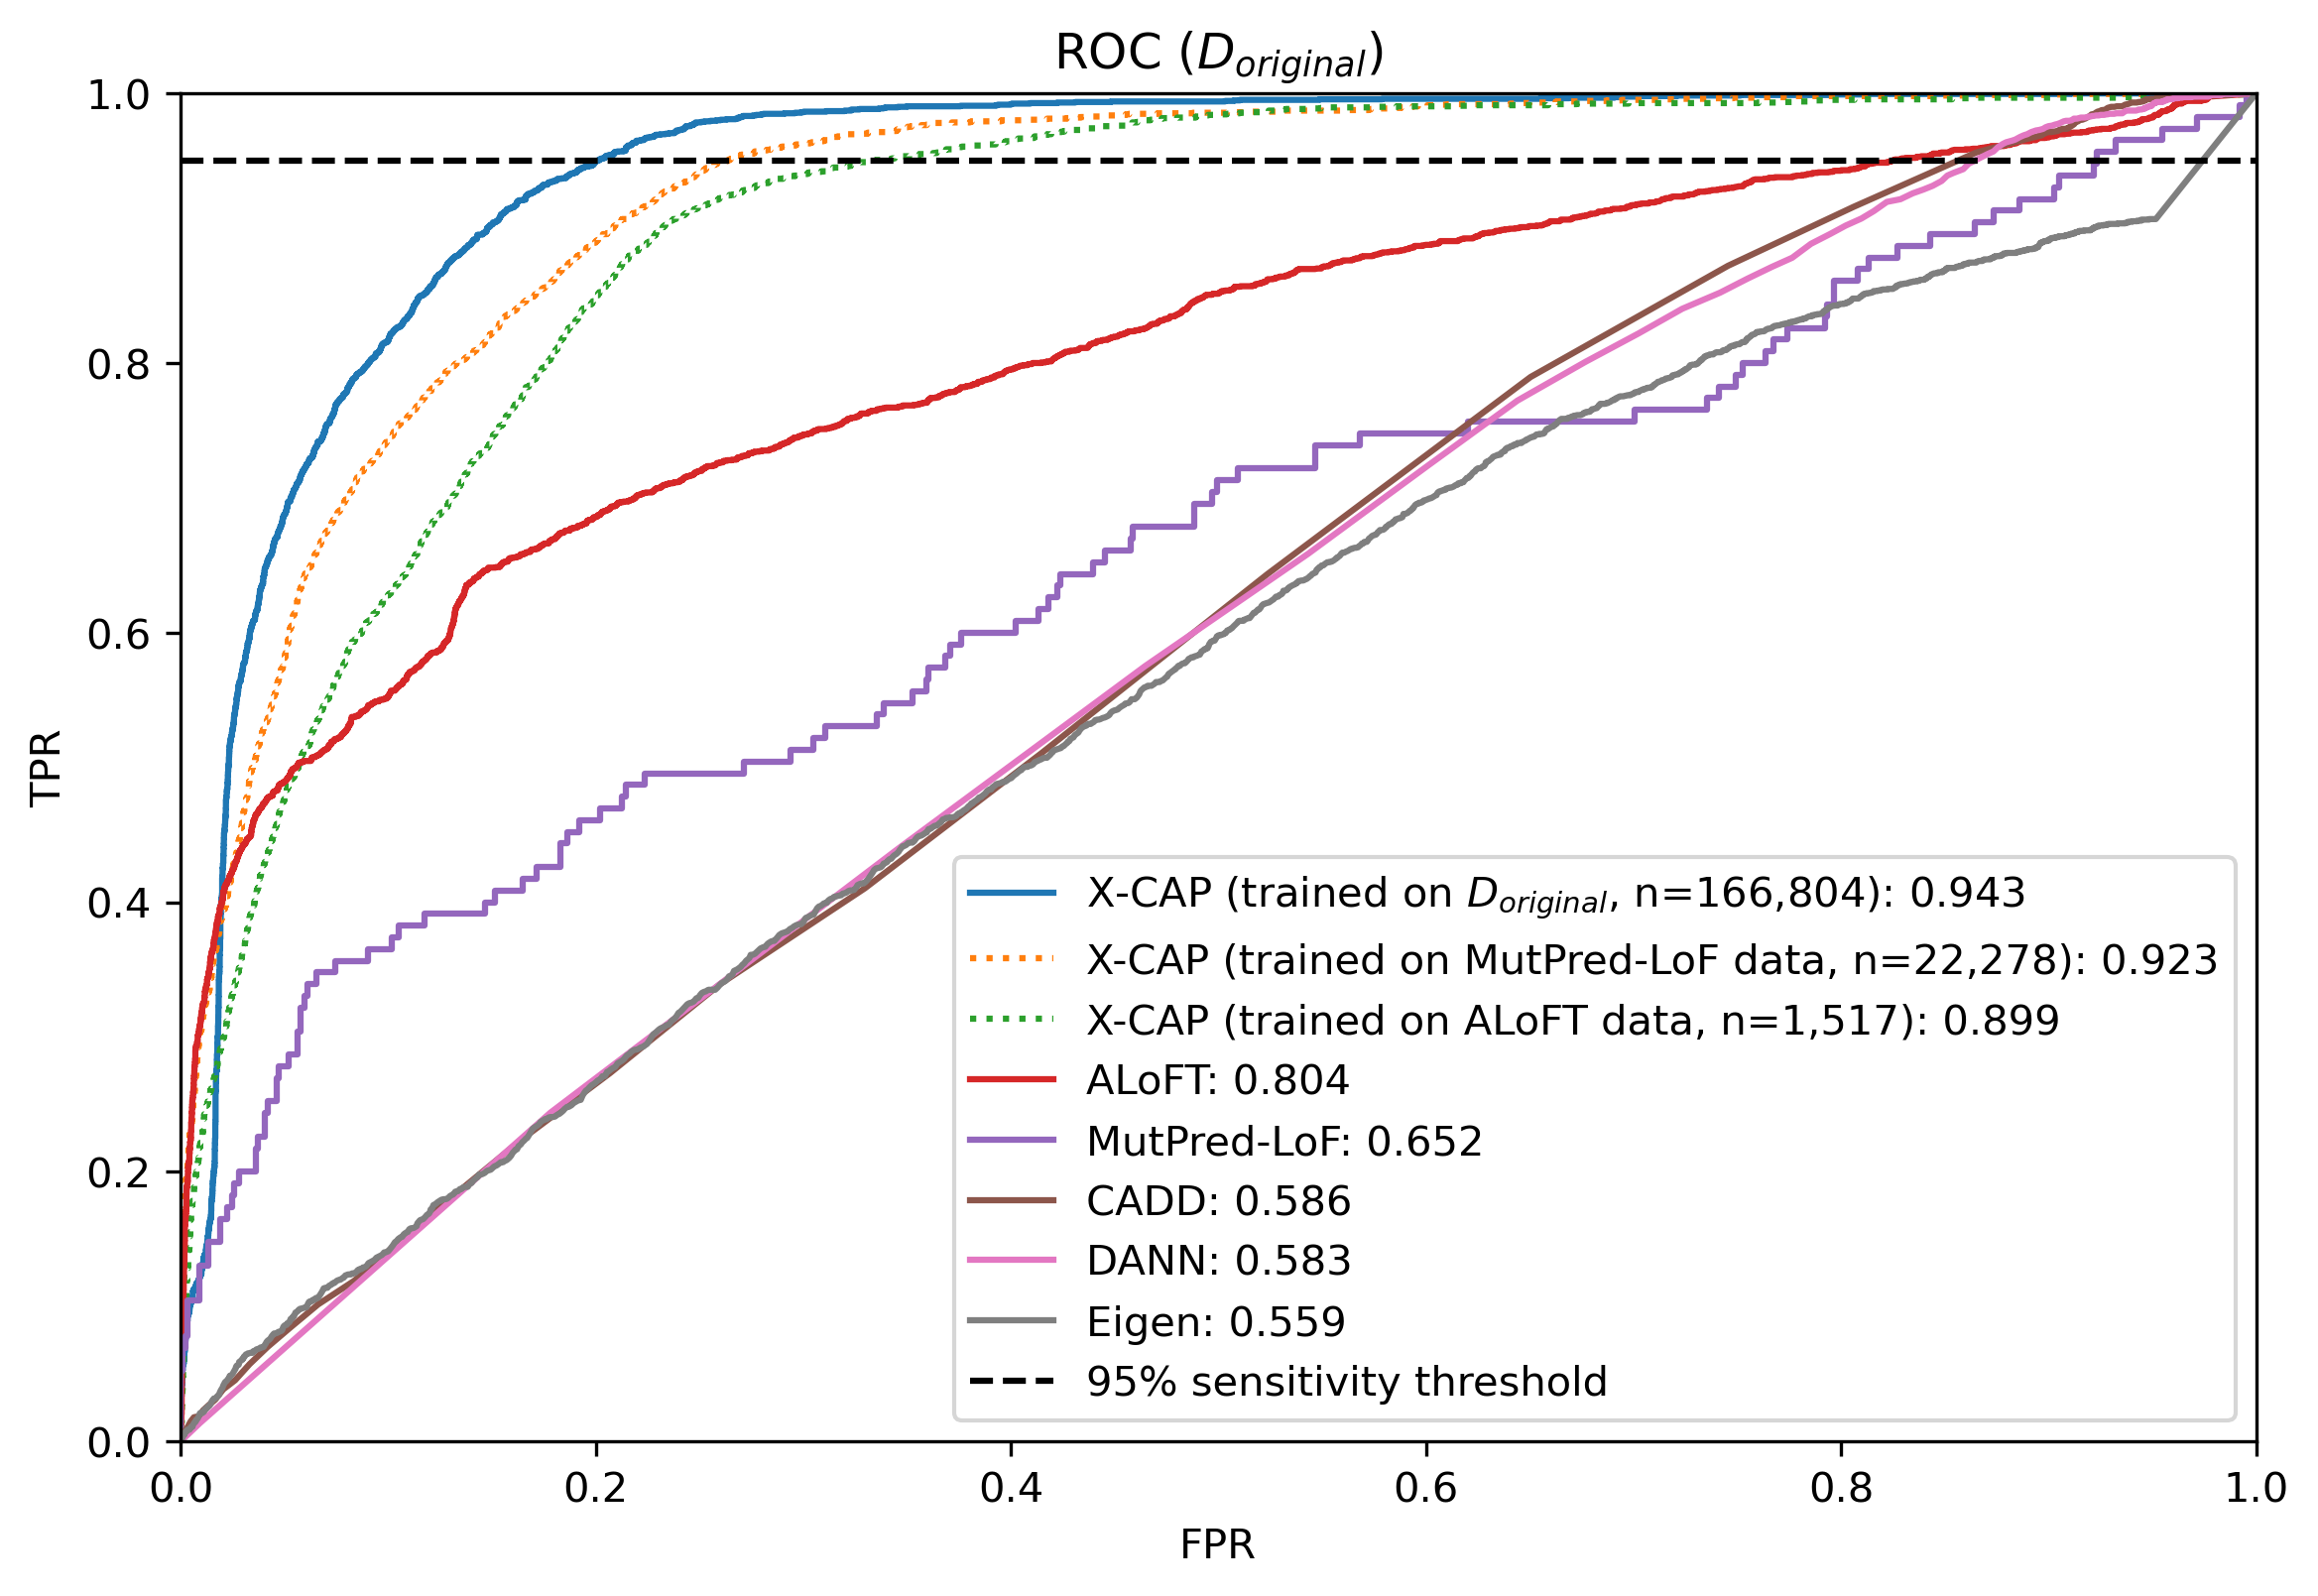

In [48]:
plotRoc(d_original=True, hsr=False)

X-CAP (trained on $D_{original}$, n=166,804): threshold=0.06011546409371992, TNR @ 95% sensitivity: 0.7992762213764273
X-CAP (trained on MutPred-LoF data, n=22,278): threshold=0.001510988808785341, TNR @ 95% sensitivity: 0.7366943283209584
X-CAP (trained on ALoFT data, n=1,517): threshold=0.3205990202127476, TNR @ 95% sensitivity: 0.6663130966494042
ALoFT: threshold=0.062275, TNR @ 95% sensitivity: 0.17551631621638486
MutPred-LoF: threshold=0.29098, TNR @ 95% sensitivity: 0.07683615819209044
CADD: threshold=33.0, TNR @ 95% sensitivity: 0.13483496599488365
DANN: threshold=0.97, TNR @ 95% sensitivity: 0.13545891308417046
Eigen: threshold=-2.007, TNR @ 95% sensitivity: 0.0


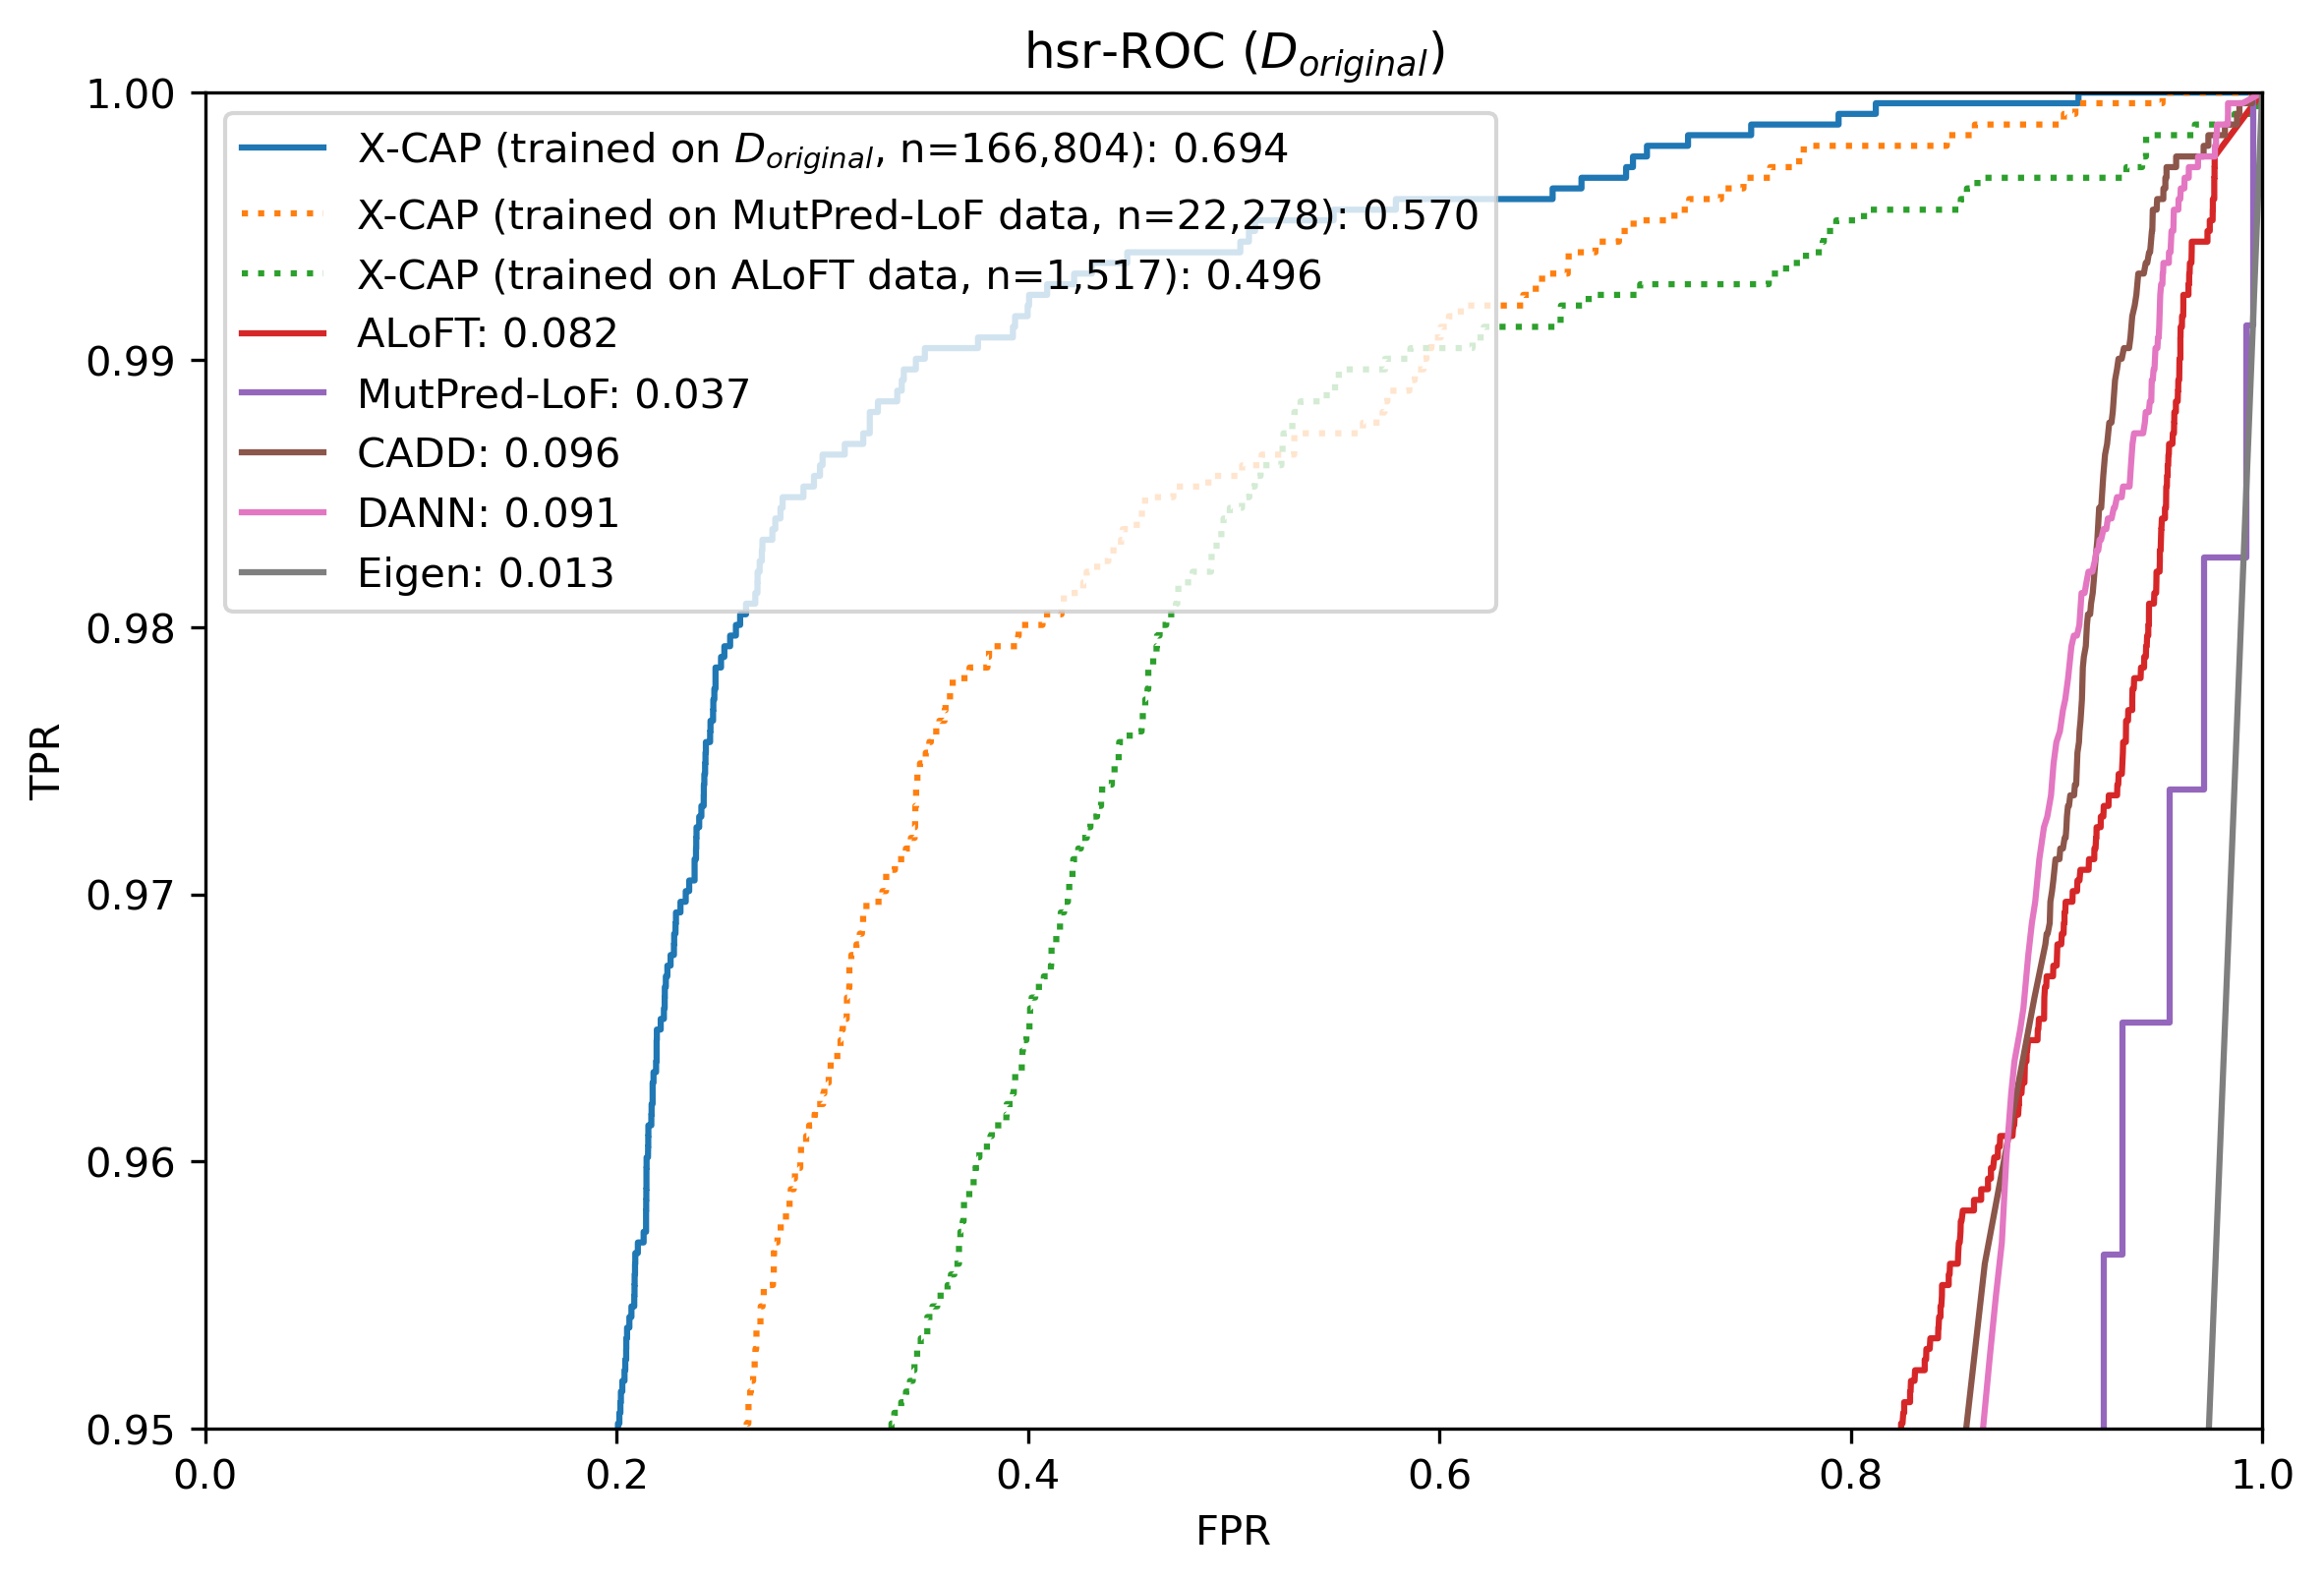

In [49]:
plotRoc(d_original=True, hsr=True)

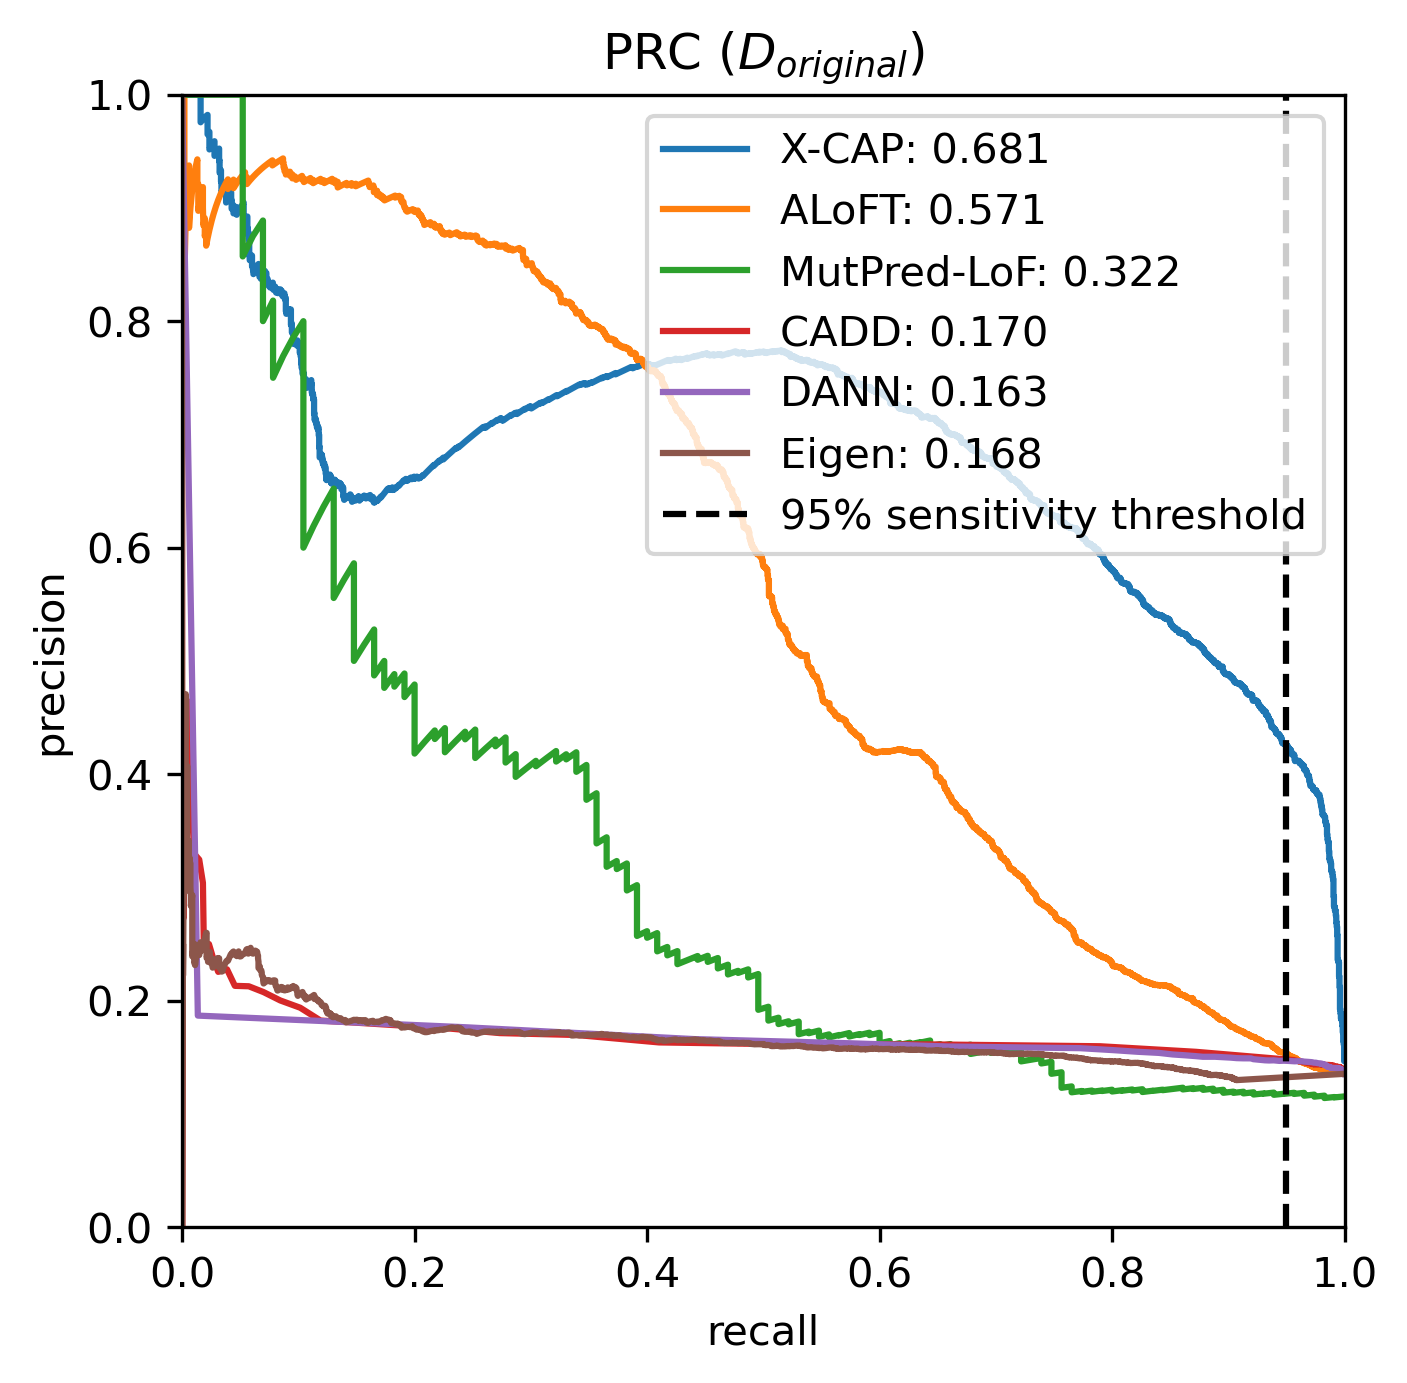

In [53]:
plotPrc(d_original=True)

# D_validation

X-CAP: threshold=0.05752546309762527, TNR @ 95% sensitivity: 0.7985341837305584
ALoFT: threshold=0.06255, TNR @ 95% sensitivity: 0.2013539218977285
MutPred-LoF: threshold=0.31211, TNR @ 95% sensitivity: 0.13096695226438193
CADD: threshold=33.0, TNR @ 95% sensitivity: 0.15631643728320466
DANN: threshold=0.971, TNR @ 95% sensitivity: 0.17929208160829513
Eigen: threshold=-2.083, TNR @ 95% sensitivity: 0.0


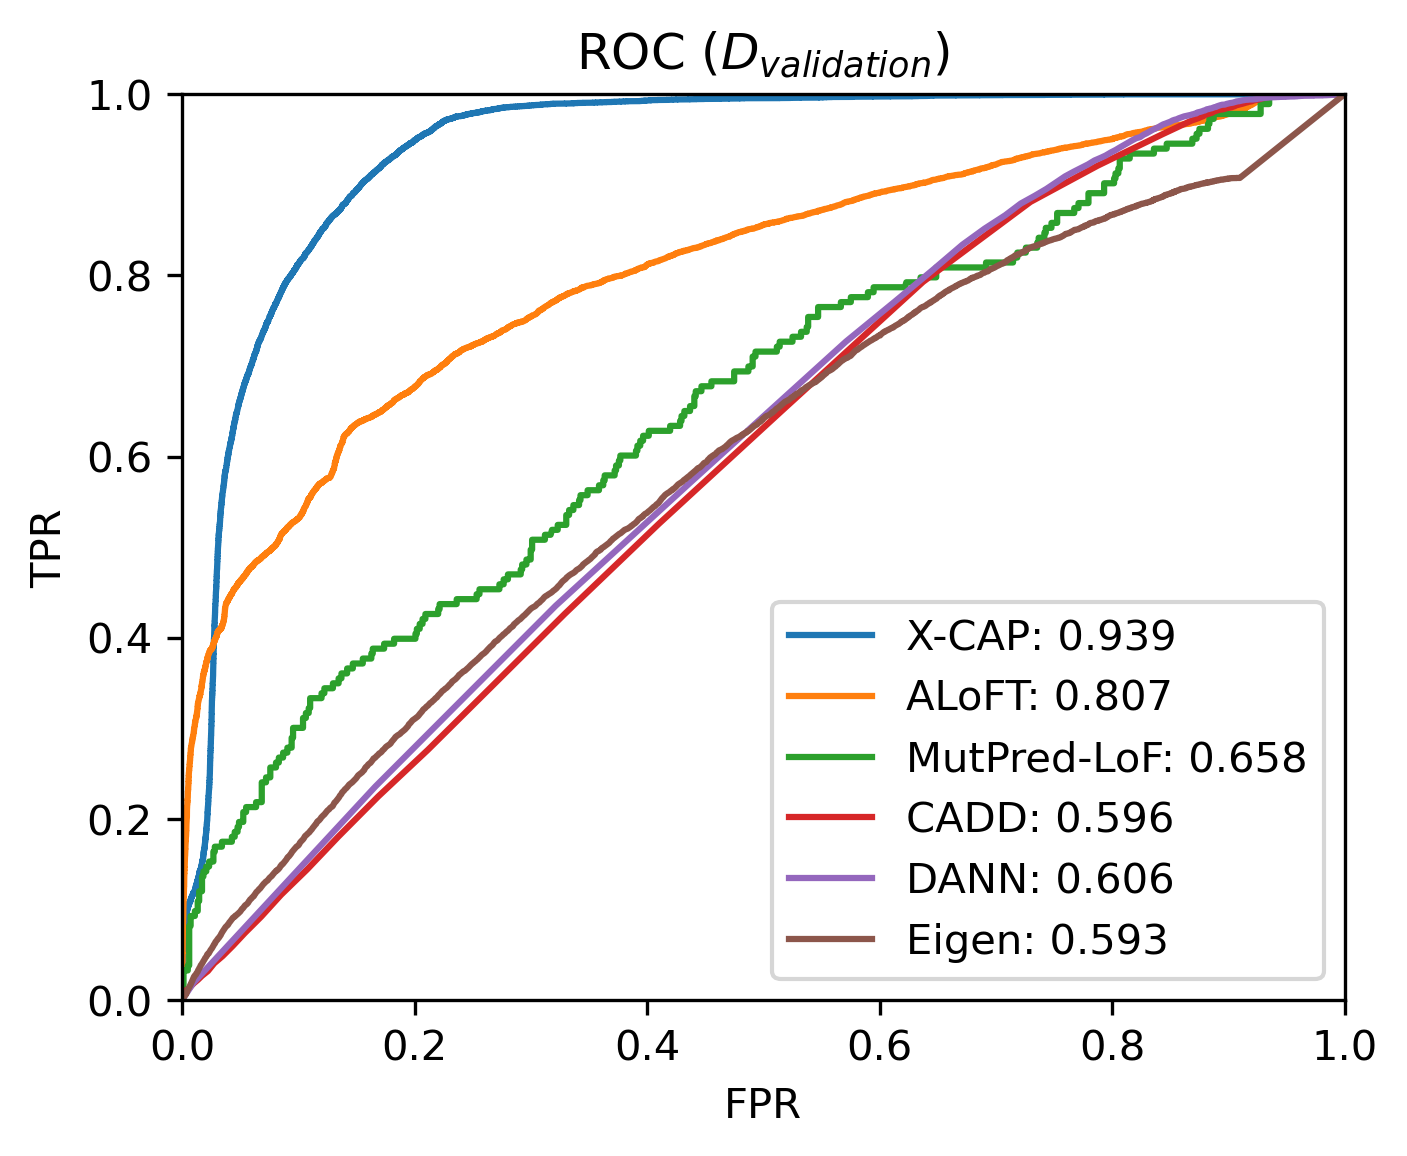

In [15]:
plotRoc(d_original=False, hsr=False)

X-CAP: threshold=0.05752546309762527, TNR @ 95% sensitivity: 0.7985341837305584
ALoFT: threshold=0.06255, TNR @ 95% sensitivity: 0.2013539218977285
MutPred-LoF: threshold=0.31211, TNR @ 95% sensitivity: 0.13096695226438193
CADD: threshold=33.0, TNR @ 95% sensitivity: 0.15631643728320466
DANN: threshold=0.971, TNR @ 95% sensitivity: 0.17929208160829513
Eigen: threshold=-2.083, TNR @ 95% sensitivity: 0.0


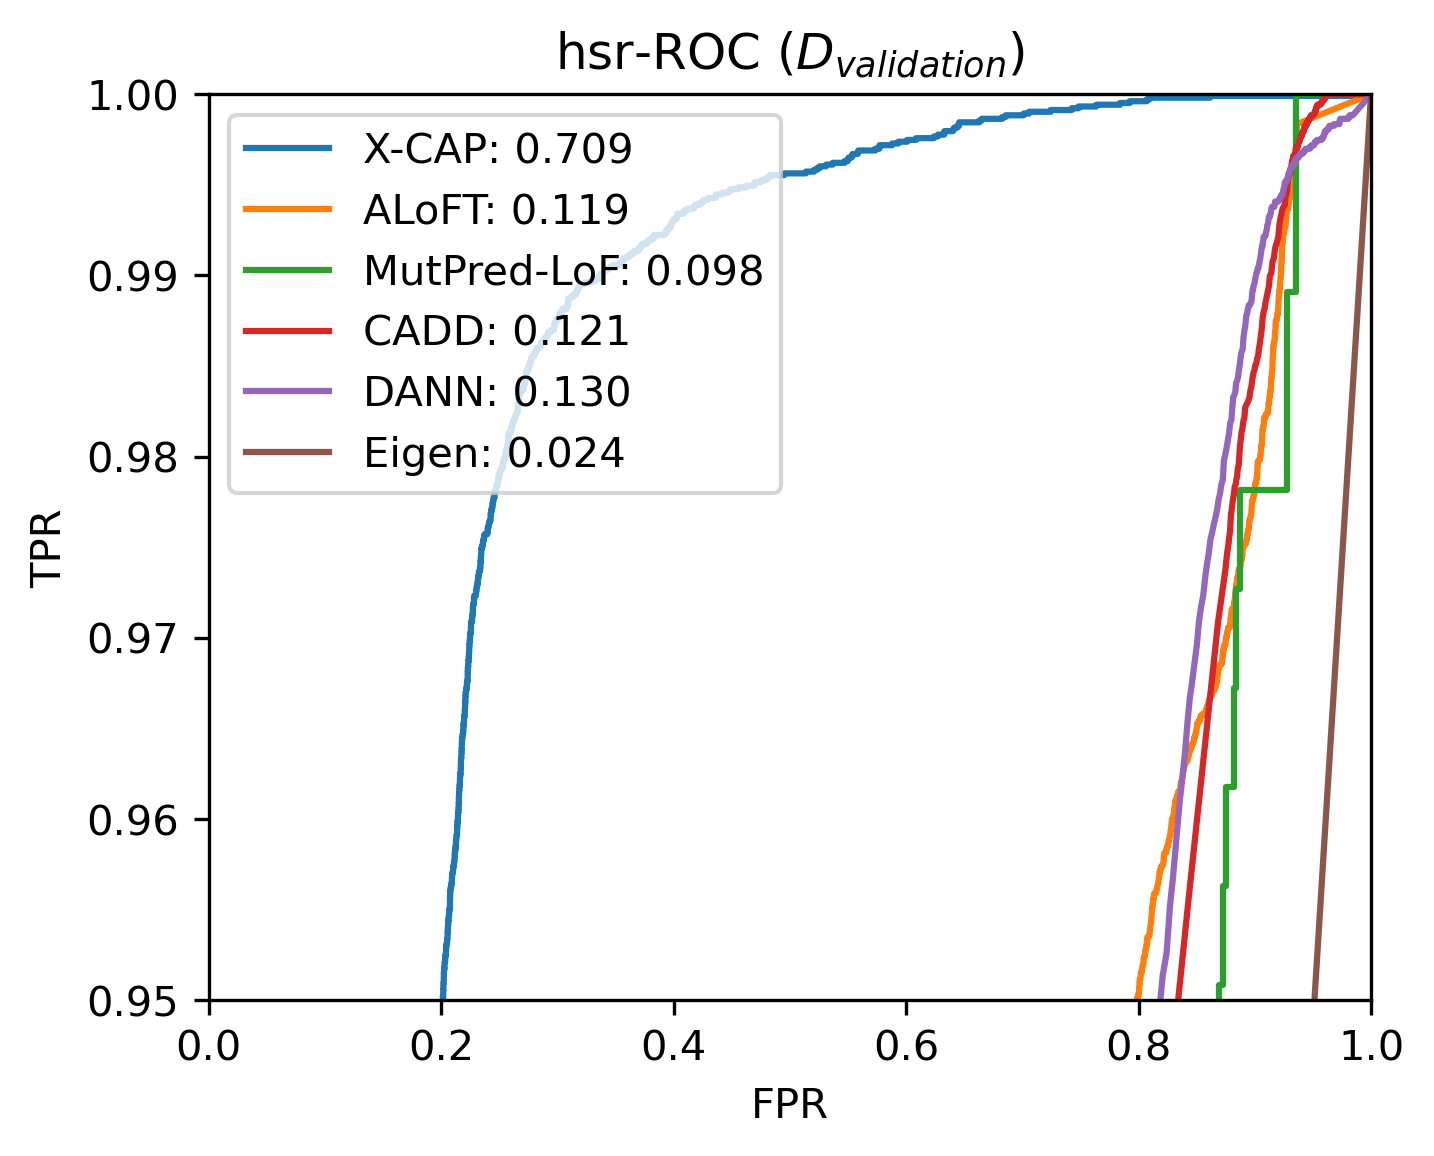

In [16]:
plotRoc(d_original=False, hsr=True)

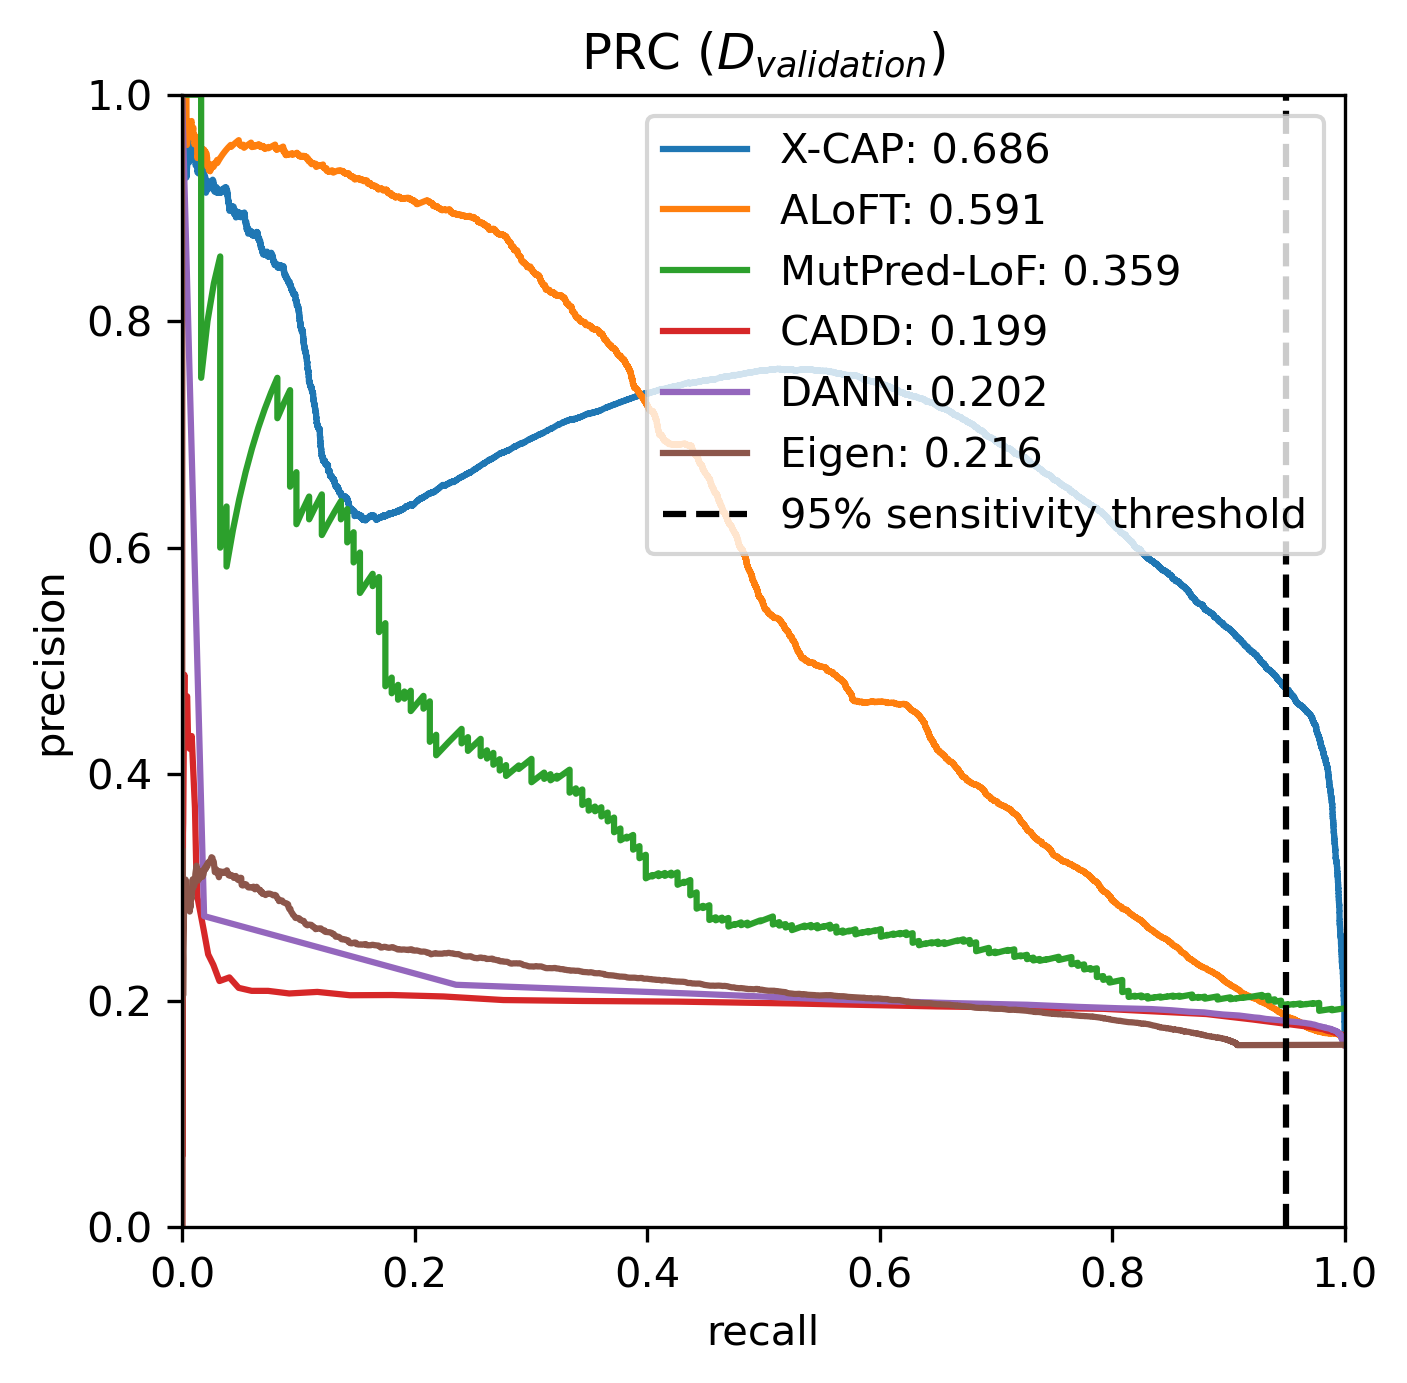

In [54]:
plotPrc(d_original=False)